In [2]:
import pandas as pd


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import shap

### 1. Processing incidents data

Aggregate the incidents data into grids with side lengths of 500m and calculate the centroid of each grid. Calculate the response time of each event. The definition of response time here is reaction seconds plus driving seconds according to the requirements.

In [3]:
incidents = pd.read_csv('Data/WMFS_datasets/wmfs_incidents.csv')
# Only pay attention to incidents of type 'FIRE' and 'FALSE_ALARM'
incidents = incidents[incidents['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]
incidents = incidents.reset_index(drop=True)

In [4]:
### Aggregate the data into grids
# Define the grid size
grid_size = 500

# Calculate the bound
xmin = incidents['EASTINGS'].min() // grid_size * grid_size # // means quotient rounding
xmax = incidents['EASTINGS'].max() // grid_size * grid_size + grid_size # rounding down so another grid needs to be added
ymin = incidents['NORTHINGS'].min() // grid_size * grid_size
ymax = incidents['NORTHINGS'].max() // grid_size * grid_size + grid_size
# Caculate the grid index
incidents['grid_x'] = ((incidents['EASTINGS'] - xmin) // grid_size).astype(int)
incidents['grid_y'] = ((incidents['NORTHINGS'] - ymin) // grid_size).astype(int)

# Add a grid_id to each incident and fire station
incidents['grid_id'] = incidents['grid_x'].astype(str) + "_" + incidents['grid_y'].astype(str)

In [5]:
# Define 'total response time'
incidents['total_response_time'] = incidents['reaction_seconds'] + incidents['driving_seconds']
incidents

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,grid_x,grid_y,grid_id,total_response_time
0,2009/1/1 0:00,False alarm raised with good intent,False Alarms,FALSE_ALARM,2,0,392062.1020,286844.9690,86,160,250,12,29,12_29,410
1,2009/1/1 0:10,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,405643.1494,277939.9802,85,65,239,39,11,39_11,304
2,2009/1/1 0:11,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410260.2444,288819.1894,62,106,115,48,33,48_33,221
3,2009/1/1 0:53,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,396779.2503,299030.1061,72,109,96,21,54,21_54,205
4,2009/1/1 0:52,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410667.9614,290492.4786,68,109,204,49,36,49_36,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292692,2023/12/31 22:59,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,398666.6867,283225.4570,88,82,281,25,22,25_22,363
292693,2023/12/31 23:11,False alarm raised with good intent,False Alarms,FALSE_ALARM,1,1,433136.8678,277909.0307,134,94,98,94,11,94_11,192
292694,2023/12/31 23:32,Accidental secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,401134.3304,277356.6820,136,152,227,30,10,30_10,379
292695,2023/12/31 23:49,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,406221.0587,290654.1816,253,66,297,40,37,40_37,363


Count the number of fires in each grid, the number of delayed fires and their proportion in this grid. Here delayed fire refers to incidents whose response time is greater than 300 seconds.

In [47]:
grid_grouped = incidents.groupby('grid_id')
distribution = []

for name, group in grid_grouped:
    # Count the fire incidents in each grid
    count = group.shape[0]
    
    # Calculate the count of incidents whose total_response_time > 300
    count_over_300 = group[group['total_response_time'] > 300].shape[0]
    
    # Calculate the proportion
    proportion_over_300 = count_over_300 / count if count > 0 else 0
    
    distribution.append([name, count, count_over_300, proportion_over_300])

grid = pd.DataFrame(distribution, columns=['grid_id', 'fire_count', 'count_over_300', 'proportion_over_300'])
grid

,grid_id,fire_count,count_over_300,proportion_over_300
0,0_51,1,1,1.000000
1,0_52,10,10,1.000000
2,0_53,4,4,1.000000
3,100_10,131,99,0.755725
4,100_11,103,48,0.466019
...,...,...,...,...
3729,9_59,27,27,1.000000
3730,9_60,42,37,0.880952
3731,9_61,63,60,0.952381
3732,9_62,59,55,0.932203


### 2. Processing feature data

In [48]:
# Load the feature dataset
dataset = pd.read_csv('Data/dataset_no_land.csv')

In [49]:
# Load the land cover data
land_corine_1 = pd.read_csv('Data/land_cover/results/land_corine_1.csv') # corine land cover 1 2018

In [50]:
# Merge the feature dataset and the proportion of delayed fires with the chosen land cover dataset
dataset_corine_1 = pd.merge(dataset, land_corine_1, on='grid_id', how='left')
final_dataset = pd.merge(grid[['grid_id', 'proportion_over_300']], dataset_corine_1.drop(columns=['median', 'percentile_90']), on='grid_id', how='left')
final_dataset

,grid_id,proportion_over_300,"Accommodation, eating and drinking",Attractions,Commercial services,Education and health,Manufacturing and production,Public infrastructure,Retail,Sport and entertainment,...,node_count,connectivity,road_length,nearest_station_distance,neighbour_frequency_per_month,station_count,Agricultural areas,Artificial surfaces,Forest and semi natural areas,Water bodies
0,0_51,1.000000,0,0,0,0,0,0,0,0,...,0,1.681265,353.287313,3187.918600,0.177778,5,100.000000,0.000000,0.0,0.0
1,0_52,1.000000,0,0,0,1,0,1,0,1,...,7,1.571429,1328.092389,2841.271722,0.194444,5,68.929306,31.070694,0.0,0.0
2,0_53,1.000000,0,1,0,1,1,1,0,0,...,1,3.000000,768.983971,2546.139234,0.188889,5,56.548633,43.451367,0.0,0.0
3,100_10,0.755725,0,2,1,2,0,4,0,2,...,11,1.545455,734.304719,1571.100570,5.922222,4,94.937310,5.062690,0.0,0.0
4,100_11,0.466019,0,1,3,0,0,1,0,1,...,20,1.800000,2987.218972,1130.202194,3.855556,4,47.371040,52.628960,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,9_59,1.000000,0,0,2,1,1,1,1,0,...,11,1.818182,2006.875970,2561.426360,1.627778,6,0.000000,100.000000,0.0,0.0
3730,9_60,0.880952,0,0,13,2,2,3,2,1,...,21,1.619048,2732.349447,2808.541436,2.211111,6,0.000000,100.000000,0.0,0.0
3731,9_61,0.952381,0,1,1,1,0,5,0,1,...,8,2.000000,1543.196315,3116.874236,2.677778,6,0.000000,100.000000,0.0,0.0
3732,9_62,0.932203,3,1,4,0,0,5,1,3,...,20,1.550000,2025.332899,3470.144810,2.005556,6,0.000000,100.000000,0.0,0.0


### 3. Processing grids with insufficient data

For grids with less than or equal to 3 data, we regard it as insufficient data.

In [51]:
grid_drop = grid[(grid['fire_count'] == 1) | (grid['fire_count'] == 2) | (grid['fire_count'] == 3)]
grid_drop

,grid_id,fire_count,count_over_300,proportion_over_300
0,0_51,1,1,1.000000
18,100_25,3,3,1.000000
57,102_7,1,1,1.000000
87,104_22,3,3,1.000000
89,105_10,1,0,0.000000
...,...,...,...,...
3623,96_6,3,3,1.000000
3643,97_6,1,1,1.000000
3663,98_6,3,3,1.000000
3687,9_17,2,1,0.500000


 If the data from these grids is used directly to build a model, it will have a certain impact on the accuracy. So we use 3 methods to process these data. 
1. **None**: No processing, just use the original data

2. **Delete**: Exclude these grids with insufficient data

3. **Interpolation**: Find num_similar grids that are similar to them, retain the data of the original grid, and use the average value to interpolate

In [52]:
# Define the function to handle insufficient data
def handle_insufficient_data(method, dataset, features_columns, grid_column='grid_id', target_column='proportion_over_300', num_similar=3):
    """
    Handle insufficient data with three methods:
    1. 'None' - Do not process the insufficient data.
    2. 'Drop' - Remove grids with insufficient data.
    3. 'Interpolation' - Use interpolation to fill in missing data.
    """
    
    # Method 1: Do not process
    if method == 'None':
        # Return features and target unchanged
        X = dataset[features_columns]
        y = dataset[target_column]
        return X, y
    
    # Method 2: Remove grids with insufficient data
    elif method == 'Drop':
        # Filter out rows with insufficient data
        filtered_dataset = dataset[~dataset[grid_column].isin(grid_drop[grid_column])]
        X = filtered_dataset[features_columns]
        y = filtered_dataset[target_column]
        return X, y
    
    # Method 3: Interpolation
    elif method == 'Interpolation':
        grid_drop_df = dataset[dataset[grid_column].isin(grid_drop[grid_column])]
        
        # Caculate cosine similarity
        def calculate_cosine_similarity(target_grid, all_grids, features_columns):
            
            target_vector = [target_grid[features_columns].values]
            all_vectors = all_grids[features_columns].values
            
            return cosine_similarity(target_vector, all_vectors).flatten()
        
        
        # Interpolation
        def interpolate_target(target_grid, similar_grids, num_similar):
            
            similar_grids_sorted = similar_grids.sort_values('similarity', ascending=False).head(num_similar)
            # combine the original median with the median values of the similar grids
            combined_y = np.append(similar_grids_sorted[target_column], target_grid[target_column])
    
            # calculate the average value
            average_y = combined_y.mean()
    
            return average_y
        
        # Apply to grid_drop_df
        def process_grid_interpolation(final_dataset, grid_drop_df, features_columns, num_similar):
            
            # Copy the target column for updates
            y_column = final_dataset[target_column].copy()
            
            for index, row in grid_drop_df.iterrows():
                # Calculate cosine similarity
                similarities = calculate_cosine_similarity(row, final_dataset, features_columns)
                similar_grids = y_column.to_frame()
                similar_grids['similarity'] = similarities
                
                # Exclude the current grid and grids with insufficient data
                similar_grids = similar_grids[similar_grids.index != row.name]
                similar_grids = similar_grids.drop(grid_drop_df.index, errors='ignore')
                
                # Interpolate the target value
                y_column.at[index] = interpolate_target(row, similar_grids, num_similar)
                
            return y_column
        
        
        # Interpolate the target column
        y = process_grid_interpolation(dataset, grid_drop_df, features_columns, num_similar)
        X = dataset[features_columns]
        return X, y



In [53]:
# Define feature columns and dynamically select target column
features_columns = final_dataset.drop(columns=['grid_id', 'proportion_over_300']).columns.tolist()

# Select the method for handling insufficient data
'''
Options: 'None', 'Drop', 'Interpolation'
'''
method = 'Interpolation'

In [54]:
# Calculate the corresponding X and y through the function
X, y = handle_insufficient_data(
    method = method,
    dataset = final_dataset,
    features_columns = features_columns,
)

In [55]:
# Check the updated results if using 'Interpolation'
final_dataset_sorted = final_dataset.sort_index()
y_sorted = y.sort_index()
comparison = final_dataset_sorted['proportion_over_300'] != y_sorted
print("Number of differences:", comparison.sum())

Number of differences: 195


### 4. Modelling

#### Lasso regression

Lasso regression itself has the  ability of selecting important features, so it can be used directly. First, we need to initialize the intercept and add a constant to each set of data.

In [56]:
X_regression = sm.add_constant(X)

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_regression, y, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Lasso model with cross-validation to find the best lambda (alpha)
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')
print(f'Best lambda (alpha): {lasso.alpha_}')

MSE: 0.023672561150846313
R²: 0.5720216833474195
Best lambda (alpha): 0.0014705038381757041


In [74]:
### Show coefficients for each feature and sort from high to low absolute value
coefficients = lasso.coef_

# Combine feature names with their corresponding coefficients
feature_names = X_regression.columns
coefficients_dict = {name: coef for name, coef in zip(feature_names, coefficients)}

# Sort the features by the absolute value of their coefficients in descending order
sorted_coefficients = dict(sorted(coefficients_dict.items(), key=lambda item: abs(item[1]), reverse=True))

# Print the sorted feature names and their coefficients
for feature, coef in sorted_coefficients.items():
    print(f"{feature}: {coef}")

nearest_station_distance: 0.15317492713414843
neighbour_frequency_per_month: -0.04726812219394431
station_count: 0.022237045354928722
Education and health: -0.017527751662679805
Sport and entertainment: -0.008110646877155977
Accommodation, eating and drinking: 0.007864989228756916
Forest and semi natural areas: 0.006354756782488885
IMD: -0.004851686618799543
road_length: -0.004653452090812002
above_65: 0.0037617751379564216
below_14: -0.0023643330281498225
Retail: 0.0018903267046819967
Transport: -0.00178244286097501
Attractions: 0.0016228030729654155
Commercial services: 0.0013858569188811515
Water bodies: -0.0006212888572728844
Manufacturing and production: -0.0005199080072777151
total_rent: -0.00048700935609362735
const: 0.0
Public infrastructure: -0.0
building_count: -0.0
node_count: 0.0
connectivity: -0.0
Agricultural areas: -0.0
Artificial surfaces: 0.0


#### Tree-based model

##### I. Feature selection


First, use random forest to select important features.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# select the features using random forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

selector = SelectFromModel(rf, threshold='median')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

In [60]:
# the value of feature importance
feature_importances = rf.feature_importances_
selected_features_mask = selector.get_support()

# get the feature importance
selected_feature_importances = feature_importances[selected_features_mask]

selected_feature_indices = np.where(selected_features_mask)[0]
selected_feature_names = np.array(X.columns)[selected_feature_indices]

sorted_indices = np.argsort(selected_feature_importances)[::-1]
sorted_importances = selected_feature_importances[sorted_indices]
sorted_feature_names = selected_feature_names[sorted_indices]

# print the selected features and their importance
for name, importance in zip(sorted_feature_names, sorted_importances):
    print(f"Name: {name}, Importance: {importance}")

Name: nearest_station_distance, Importance: 0.7554825915341961
Name: neighbour_frequency_per_month, Importance: 0.0303334968628477
Name: IMD, Importance: 0.019306992984623673
Name: station_count, Importance: 0.017732652793041804
Name: building_count, Importance: 0.016990550248936576
Name: total_rent, Importance: 0.016940839985658342
Name: above_65, Importance: 0.016902494171563438
Name: road_length, Importance: 0.01585449867985468
Name: connectivity, Importance: 0.015125468964978905
Name: below_14, Importance: 0.014081021886304692
Name: Commercial services, Importance: 0.011571322068632674
Name: node_count, Importance: 0.00916906756342827


##### II. Random Forest regression

For Random Forest, we perform a grid search on the number of trees *(n_estimators)*, the depth of the maximum tree *(max_depth)* and the minimum number of leaf node samples *(min_samples_split)*.

In [61]:
### Random forest regression
# Tuning the hyperparameters using grid search with cross validation
rf_hyperparameters = {
    'n_estimators': [250, 300, 350],
    'max_depth': [8, 10, 12],
    'min_samples_split': [8, 10, 12, 15]
}

rf = RandomForestRegressor(random_state=0)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_hyperparameters, cv=5, n_jobs=-1, verbose=2)

# Train the model
rf_grid_search.fit(X_train_selected, y_train)

# Extract the best hyperparameters
rf_best_params = rf_grid_search.best_params_
rf_best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   5.8s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   5.8s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   5.9s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   5.9s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=250; total time=   5.8s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   6.9s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.0s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.1s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.0s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=300; total time=   7.0s
[CV] END .max_depth=8, min_samples_split=8, n_estimators=350; total time=   8.3s
[CV] END .max_depth=8, min_samples_split=8, n_e

{'max_depth': 8, 'min_samples_split': 15, 'n_estimators': 350}

In [62]:
rf_model = RandomForestRegressor(
    n_estimators=rf_best_params['n_estimators'],
    max_depth=rf_best_params['max_depth'],
    min_samples_split=rf_best_params['min_samples_split'],
    random_state=0)

rf_model.fit(X_train_selected, y_train)
y_pred_rf = rf_model.predict(X_test_selected)

print(f'Random Forest MSE: {mean_squared_error(y_test, y_pred_rf)}')
print(f'Random Forest R²: {r2_score(y_test, y_pred_rf)}')

Random Forest MSE: 0.01342113639112237
Random Forest R²: 0.757358093886183


##### III. XGBoost

For XGBoost, we perform a grid search on the number of trees *(n_estimators)*, the depth of the maximum tree *(max_depth)*, the minimum number of leaf node samples *(min_samples_split)*, the sample sampling ratio *(subsample)* and the feature sampling ratio *(colsample_bytree)*.

In [64]:
# Tuning the hyperparameters using grid search with cross validation
xgb_hyperparameters = {
    'n_estimators': [300, 400, 500],      
    'max_depth': [4, 5, 6],            
    'learning_rate': [0.005, 0.01, 0.02], 
    'subsample': [0.8],
    'colsample_bytree': [1] 
}

xgb = XGBRegressor(random_state=0)

# Train the model
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_hyperparameters, cv=5, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)

# Extract the best hyperparameters
xgb_best_params = xgb_grid_search.best_params_
xgb_best_params

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=300, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=400, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=400, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=1, learning_rate=0.005, max_depth=4, n_estimators=400, subsample=0.8; total time=   1.7s
[CV] END colsample

{'colsample_bytree': 1,
 'learning_rate': 0.02,
 'max_depth': 4,
 'n_estimators': 400,
 'subsample': 0.8}

In [65]:
# XGBoost regression
xgb_model = XGBRegressor(
    n_estimators=xgb_best_params['n_estimators'],
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    random_state=0)
xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)

print(f'XGBoost MSE: {mean_squared_error(y_test, y_pred_xgb)}')
print(f'XGBoost R²: {r2_score(y_test, y_pred_xgb)}')

XGBoost MSE: 0.012603241378243518
XGBoost R²: 0.7721448898133284


### 5. Plotting

#### I. Partial Dependency Plot

Plot the Partial Dependency Plots of Random Forest and XGBoost separately for the top five most important features.

In [66]:
top_n = 2
top_indices = list(sorted_indices)[:top_n]

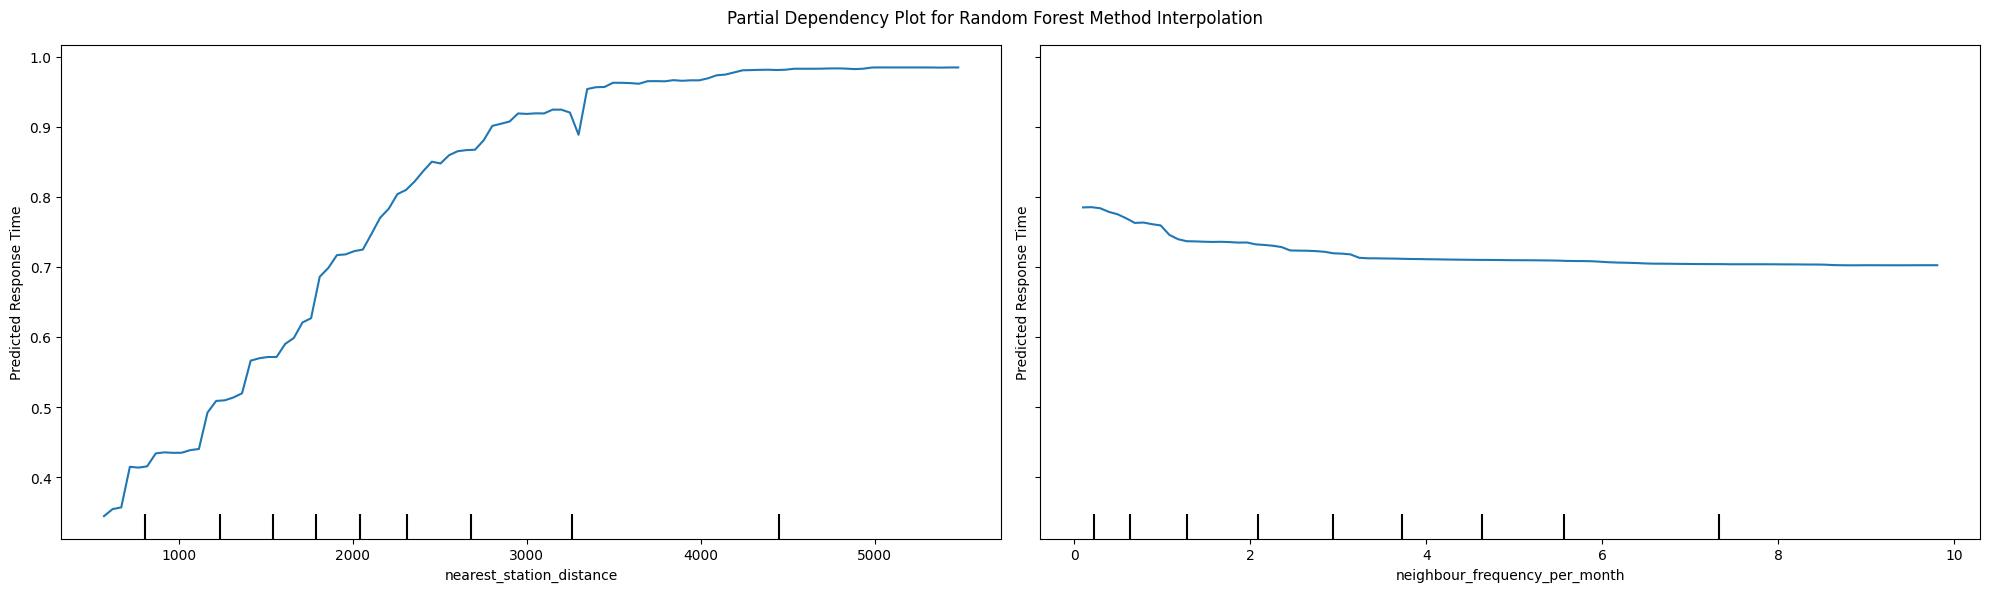

In [67]:
### Random Forest
# Create multiple subplots
fig, ax = plt.subplots(1, top_n, figsize=(20, 6), sharey=True)

pdp_display = PartialDependenceDisplay.from_estimator(rf_model, X_test_selected, features=top_indices, ax=ax)

# Set x and y axis labels
for i, axi in enumerate(ax):
    feature_name = sorted_feature_names[i]
    axi.set_xlabel(feature_name)
    axi.set_ylabel('Predicted Response Time')

fig.suptitle(f"Partial Dependency Plot for Random Forest Method {method}")

plt.tight_layout()
plt.show()

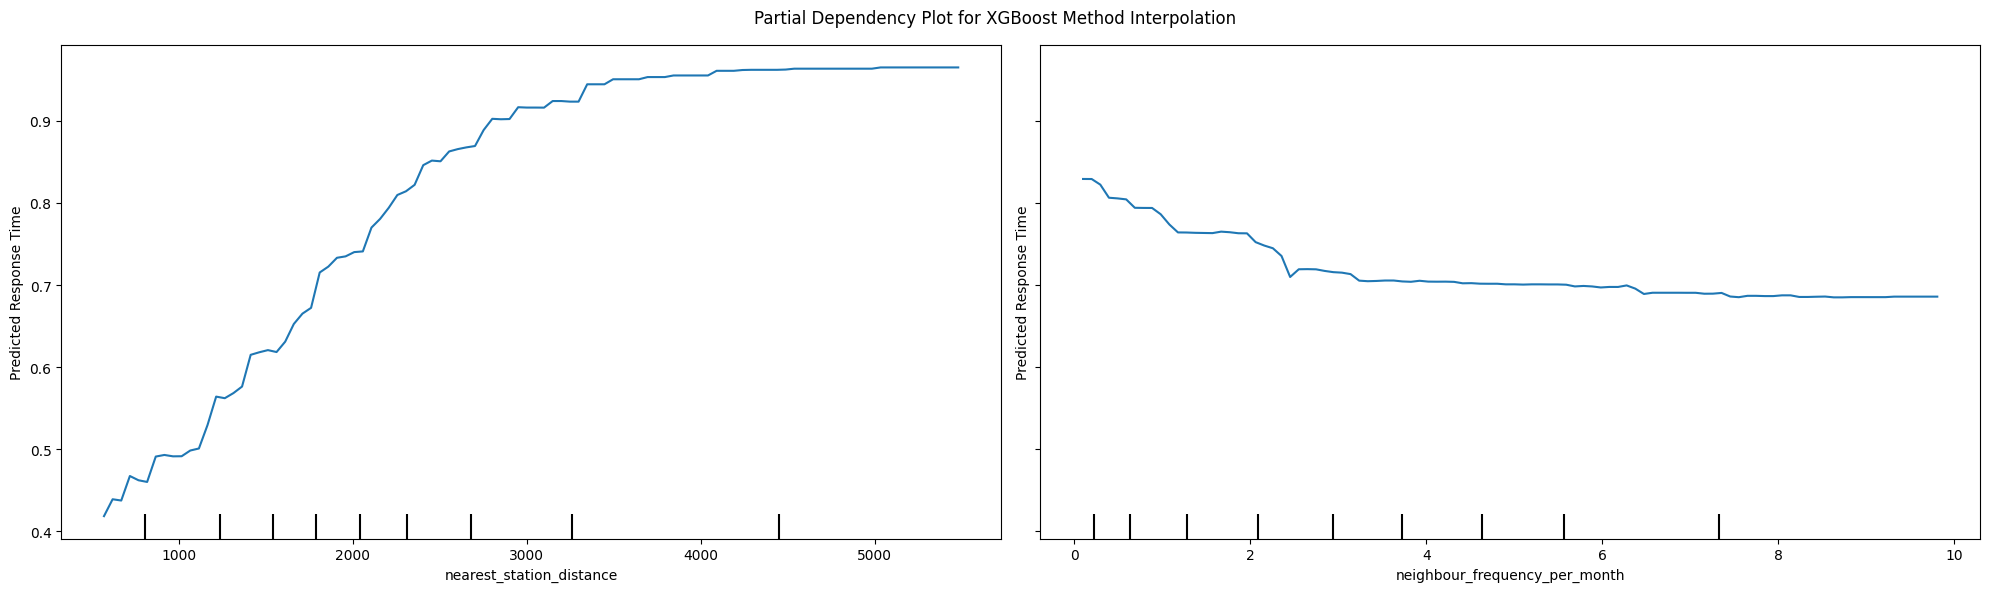

In [68]:
### XGBoost
# Create multiple subplots
fig, ax = plt.subplots(1, top_n, figsize=(20, 6), sharey=True)

pdp_display = PartialDependenceDisplay.from_estimator(xgb_model, X_test_selected, features=top_indices, ax=ax)

# Set x and y axis labels
for i, axi in enumerate(ax):
    feature_name = sorted_feature_names[i]
    axi.set_xlabel(feature_name)
    axi.set_ylabel('Predicted Response Time')

fig.suptitle(f"Partial Dependency Plot for XGBoost Method {method}")

plt.tight_layout()
plt.show()

#### II. SHAP

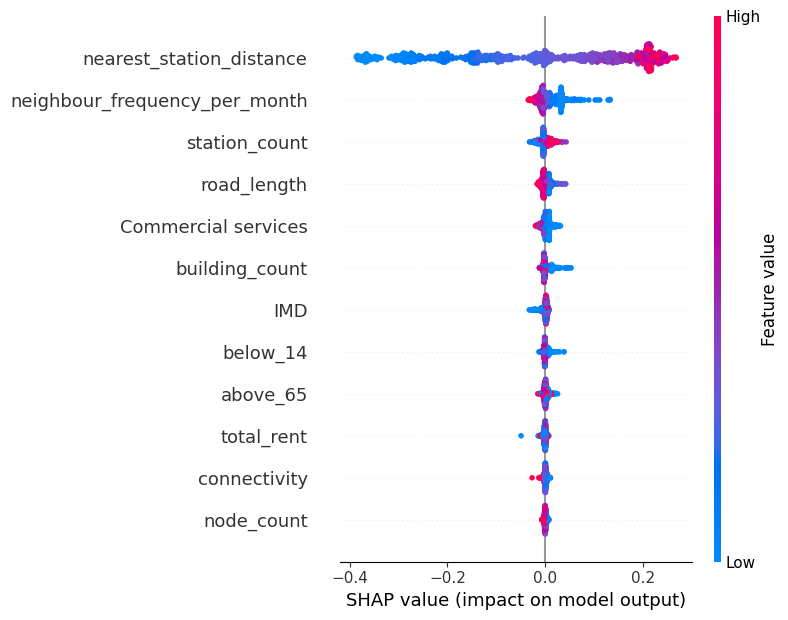

In [72]:
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test_selected)

shap.summary_plot(rf_shap_values, X_test_selected, feature_names=selected_feature_names)

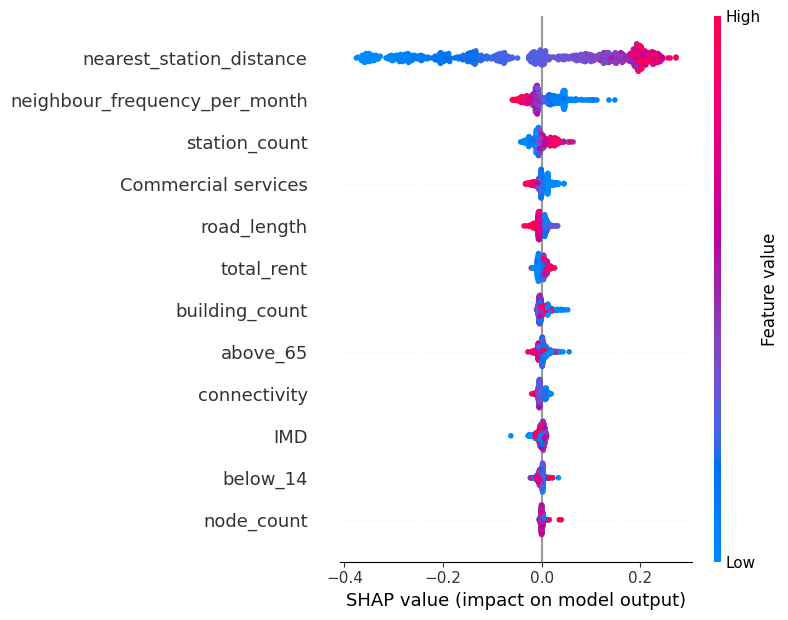

In [73]:
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test_selected)

shap.summary_plot(xgb_shap_values, X_test_selected, feature_names=selected_feature_names)